<a href="https://colab.research.google.com/github/cildiroyku/TransferLearningforAnimalSounds/blob/main/DLProject_EmbeddingsOyku.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install torch-vggish-yamnet #PyTorch wrapper library that lets you load and use YAMNet it gives pretrained YAMNet embeddings


In [2]:
#It downloads the ZIP file containing the ESC-50 dataset and extracts all the .wav audio files.
!wget https://github.com/karoldvl/ESC-50/archive/master.zip
!unzip master.zip -d ESC50


--2025-11-17 17:22:11--  https://github.com/karoldvl/ESC-50/archive/master.zip
Resolving github.com (github.com)... 20.205.243.166
Connecting to github.com (github.com)|20.205.243.166|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://github.com/karolpiczak/ESC-50/archive/master.zip [following]
--2025-11-17 17:22:11--  https://github.com/karolpiczak/ESC-50/archive/master.zip
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://codeload.github.com/karolpiczak/ESC-50/zip/refs/heads/master [following]
--2025-11-17 17:22:11--  https://codeload.github.com/karolpiczak/ESC-50/zip/refs/heads/master
Resolving codeload.github.com (codeload.github.com)... 20.205.243.165
Connecting to codeload.github.com (codeload.github.com)|20.205.243.165|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 645695005 (616M) [application/zip]
Saving to: ‘master.zip’

master.zip       

In [3]:
#Download GTZAN
import kagglehub

path = kagglehub.dataset_download("andradaolteanu/gtzan-dataset-music-genre-classification")
print("Dataset downloaded to:", path)


Using Colab cache for faster access to the 'gtzan-dataset-music-genre-classification' dataset.
Dataset downloaded to: /kaggle/input/gtzan-dataset-music-genre-classification


In [4]:
# This code loads an audio file, converts it into YAMNet’s required log-mel format, runs the frozen YAMNet model, and returns a final 1024-dimensional embedding for that sound clip.

import torch, torchaudio, soundfile as sf
from torch_vggish_yamnet import yamnet
from torch_vggish_yamnet.input_proc import WaveformToInput

device = "cuda" if torch.cuda.is_available() else "cpu"

# Load pretrained YAMNet and the waveform→input converter
yamnet_model = yamnet.yamnet(pretrained=True).to(device).eval()
yamnet_converter = WaveformToInput()

@torch.no_grad()
def wav_to_yamnet_embedding(wave: torch.Tensor, sr: int):
    """
    wave: torch.Tensor of shape (channels, samples) or (samples,)
    sr: sampling rate
    returns: np.ndarray of shape (1024,) – frame-averaged YAMNet embedding
    """
    # Ensure shape (1, samples)
    if wave.ndim == 1:
        wave = wave.unsqueeze(0)
    # Resample to 16 kHz mono (YAMNet expects 16k)
    if sr != 16000:
        wave = torchaudio.functional.resample(wave, sr, 16000)
        sr = 16000
    wave = wave.mean(0, keepdim=True)  # mono

    x = yamnet_converter(wave.float(), sr).to(device)  # frames × features
    emb, _ = yamnet_model(x)                           # (frames, 1024)
    emb = emb.mean(dim=0).cpu().numpy()                # -> (1024,)
    # Ensure it's a 1D array (1024,) not (1024, 1, 1)
    emb = emb.flatten() if emb.ndim > 1 else emb
    return emb

def safe_load(fp):
    """Try torchaudio first, fallback to soundfile; always return (wave, sr)."""
    try:
        wave, sr = torchaudio.load(fp)
        return wave, sr
    except Exception:
        data, sr = sf.read(fp, dtype="float32")  # (samples,) or (samples, channels)
        if data.ndim == 1:
            data = data[:, None]                 # -> (samples, 1)
        wave = torch.from_numpy(data.T)          # -> (channels, samples)
        return wave, sr


Downloading: "https://github.com/w-hc/torch_audioset/releases/download/v0.1/yamnet.pth" to /root/.cache/torch/hub/checkpoints/yamnet.pth


100%|██████████| 14.4M/14.4M [00:00<00:00, 433MB/s]


In [5]:
# This code converts all ESC-50 audio clips into YAMNet’s 1024-dimensional
# embeddings and builds the dataset that will be used for zero-shot, few-shot,
# and full classification experiments.

import os
import numpy as np
import pandas as pd
from tqdm import tqdm

# 1) Paths to ESC-50 (as you already used when downloading/unzipping)
esc_root  = "ESC50/ESC-50-master"
esc_csv   = os.path.join(esc_root, "meta/esc50.csv")
esc_audio = os.path.join(esc_root, "audio")

# 2) Load metadata (filenames + categories)
esc_meta = pd.read_csv(esc_csv)

# 3) Prepare containers
X, y = [], []

# Map category name -> numeric id (0..49)
label_to_id = {lbl: i for i, lbl in enumerate(sorted(esc_meta["category"].unique()))}

# 4) Loop over all ESC-50 audio files and extract a 1024-dim embedding
for row in tqdm(esc_meta.itertuples(index=False), total=len(esc_meta)):
    wav_path = os.path.join(esc_audio, row.filename)
    try:
        # use your helper functions from the first cell
        wave, sr = safe_load(wav_path)
        emb = wav_to_yamnet_embedding(wave, sr)   # shape (1024,)
        X.append(emb)
        y.append(label_to_id[row.category])       # integer label
    except Exception as e:
        print("Failed:", wav_path, "->", e)

# 5) Stack into arrays
X = np.stack(X).astype("float32")   # shape (N, 1024)
y = np.array(y, dtype=np.int64)     # shape (N,)

print("ESC-50 embeddings shape:", X.shape)
print("ESC-50 labels shape:", y.shape)

# 6) (Optional) Save to disk for later use
np.savez_compressed("esc50_yamnet.npz",
                    X=X,
                    y=y,
                    labels=np.array(sorted(label_to_id, key=label_to_id.get)))


  0%|          | 0/2000 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.decoders.AudioDecoder.html#torchcodec.decoders.AudioDecoder.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/ffmpeg.py:88: UserWarning: torio.io._streaming_media_decoder.StreamingMediaDecoder has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. The decoding and encoding capabilities of PyTorch for both audio and video are being consolidated into TorchCodec. Please see https://github.com/pytorch/audio/issues

ESC-50 embeddings shape: (2000, 1024)
ESC-50 labels shape: (2000,)


In [6]:
# This cell converts all GTZAN audio clips into 1024-D YAMNet embeddings

import os
import numpy as np
from tqdm import tqdm

# 1) Root folder to the GTZAN dataset
# If you used kagglehub.dataset_download, you probably have something like:
# path = kagglehub.dataset_download("andradaolteanu/gtzan-dataset-music-genre-classification")
# If not, set this manually:
# path = "/kaggle/input/gtzan-dataset-music-genre-classification"

gtzan_root = os.path.join(path, "Data", "genres_original")
print("Using GTZAN root:", gtzan_root)
assert os.path.isdir(gtzan_root)

# 2) Get genre subfolders
genres = sorted(
    d for d in os.listdir(gtzan_root)
    if os.path.isdir(os.path.join(gtzan_root, d))
)
print("Detected genres:", genres)

# 3) Prepare containers
X, y = [], []
label_to_id = {g: i for i, g in enumerate(genres)}
print("Label→id mapping:", label_to_id)

# 4) Loop over all files and extract one 1024-D embedding per clip
failed_files = []
for genre in genres:
    genre_id = label_to_id[genre]
    folder = os.path.join(gtzan_root, genre)
    wav_files = sorted(
        f for f in os.listdir(folder)
        if f.lower().endswith(".wav")
    )

    for fn in tqdm(wav_files, desc=f"Processing {genre}", leave=False):
        wav_path = os.path.join(folder, fn)
        try:
            wave, sr = safe_load(wav_path)
            emb = wav_to_yamnet_embedding(wave, sr)  # (1024,)
            X.append(emb)
            y.append(genre_id)
        except Exception as e:
            failed_files.append((wav_path, str(e)))
            print(f"Failed: {wav_path} -> {e}")

# Report summary of failed files
if failed_files:
    print(f"\n Total failed files: {len(failed_files)}")
    print("Failed files by genre:")
    for path, error in failed_files:
        genre_name = path.split('/')[-2]  # Extract genre from path
        print(f"  {genre_name}: {os.path.basename(path)}")
else:
    print("\n All files processed successfully!")

# 5) Stack into arrays
X = np.stack(X).astype("float32")  # shape (N, 1024)
y = np.array(y, dtype=np.int64)    # shape (N,)

print("GTZAN embeddings shape:", X.shape)
print("GTZAN labels shape:", y.shape)

# 6) Save to disk for later (for your linear SVM, NC, etc.)
np.savez_compressed(
    "gtzan_yamnet.npz",
    X=X,
    y=y,
    labels=np.array(genres)
)
print("Saved gtzan_yamnet.npz")


Using GTZAN root: /kaggle/input/gtzan-dataset-music-genre-classification/Data/genres_original
Detected genres: ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']
Label→id mapping: {'blues': 0, 'classical': 1, 'country': 2, 'disco': 3, 'hiphop': 4, 'jazz': 5, 'metal': 6, 'pop': 7, 'reggae': 8, 'rock': 9}


Processing jazz:  58%|█████▊    | 58/100 [00:03<00:02, 18.13it/s]

Failed: /kaggle/input/gtzan-dataset-music-genre-classification/Data/genres_original/jazz/jazz.00054.wav -> Error opening '/kaggle/input/gtzan-dataset-music-genre-classification/Data/genres_original/jazz/jazz.00054.wav': Format not recognised.



 Total failed files: 1
Failed files by genre:
  jazz: jazz.00054.wav
GTZAN embeddings shape: (999, 1024)
GTZAN labels shape: (999,)
Saved gtzan_yamnet.npz


## Loading Embeddings

In [7]:
import numpy as np
import pandas as pd
import os

def flatten_embeddings(X):
    """
    Converts embeddings of shape (N, *, 1024) → (N, 1024)
    by reshaping/flattening extra dimensions.
    """
    X = np.asarray(X)

    # If already correct shape, return as is
    if X.ndim == 2 and X.shape[1] == 1024:
        return X

    # Find the dimension that is 1024
    embed_dim = None
    for i, s in enumerate(X.shape):
        if s == 1024:
            embed_dim = i
            break

    if embed_dim is None:
        raise ValueError(f"Could not find dimension of size 1024 in shape {X.shape}")

    # Move 1024 to last axis
    X = np.moveaxis(X, embed_dim, -1)

    # Reshape to (N, 1024) - flatten all dimensions except first and last
    if X.ndim > 2:
        # Reshape: keep first dim, flatten middle dims, keep last dim (1024)
        new_shape = (X.shape[0], -1, X.shape[-1])
        X = X.reshape(new_shape)
        # If still more than 2 dims, squeeze middle dims
        while X.ndim > 2:
            X = X.squeeze(axis=1) if X.shape[1] == 1 else X.reshape(X.shape[0], -1)

    return X

# Load embeddings
esc = np.load("esc50_yamnet.npz")
X_esc, y_esc = esc["X"], esc["y"]
esc_labels = esc["labels"] if "labels" in esc.keys() else None

gtz = np.load("gtzan_yamnet.npz")
X_gtzan, y_gtzan = gtz["X"], gtz["y"]
gtzan_labels = gtz["labels"] if "labels" in gtz.keys() else None

print("Original ESC-50 shape:", X_esc.shape, y_esc.shape)
print("Original GTZAN shape:", X_gtzan.shape, y_gtzan.shape)

# Load ESC-50 metadata to get category names
esc_root = "ESC50/ESC-50-master"
esc_csv = os.path.join(esc_root, "meta/esc50.csv")
esc_meta = pd.read_csv(esc_csv)

# Get all unique categories from metadata
all_categories = sorted(esc_meta["category"].unique())
print(f"\nTotal ESC-50 categories: {len(all_categories)}")
print(f"ESC-50 categories: {all_categories[:10]}... (showing first 10)")

# Flatten embeddings if needed
X_esc_flat = flatten_embeddings(X_esc)
X_gtzan_flat = flatten_embeddings(X_gtzan)

print(f"\nFlattened ESC-50 shape: {X_esc_flat.shape}")
print(f"Flattened GTZAN shape: {X_gtzan_flat.shape}")
print(f"ESC-50 number of classes: {len(np.unique(y_esc))}")
print(f"GTZAN number of classes: {len(np.unique(y_gtzan))}")
print(f"Samples per ESC-50 class: {np.bincount(y_esc)}")

# Verify shapes are correct
assert X_esc_flat.shape == (len(y_esc), 1024), f"ESC-50 shape mismatch: {X_esc_flat.shape}"
assert X_gtzan_flat.shape == (len(y_gtzan), 1024), f"GTZAN shape mismatch: {X_gtzan_flat.shape}"
print("\n✅ Embedding shapes verified!")

Original ESC-50 shape: (2000, 1024) (2000,)
Original GTZAN shape: (999, 1024) (999,)

Total ESC-50 categories: 50
ESC-50 categories: ['airplane', 'breathing', 'brushing_teeth', 'can_opening', 'car_horn', 'cat', 'chainsaw', 'chirping_birds', 'church_bells', 'clapping']... (showing first 10)

Flattened ESC-50 shape: (2000, 1024)
Flattened GTZAN shape: (999, 1024)
ESC-50 number of classes: 50
GTZAN number of classes: 10
Samples per ESC-50 class: [40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40
 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40
 40 40]

✅ Embedding shapes verified!


In [8]:
# Note: flatten_embeddings() is already defined in the previous cell
# This cell is kept for backward compatibility but the function is defined above
# The embeddings are already flattened in cell 8


## Zero-Shot Experiments

In [9]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

def zero_shot_baseline(clf, X_src, y_src, X_tgt, y_tgt, return_all_metrics=False):
    """
    Zero-shot transfer: train on source (GTZAN), test on target (ESC-50 animals)
    Returns accuracy, macro-F1, and optionally confusion matrix
    """
    scaler = StandardScaler()
    X_src_s = scaler.fit_transform(X_src)
    X_tgt_s = scaler.transform(X_tgt)

    clf.fit(X_src_s, y_src)
    preds = clf.predict(X_tgt_s)

    acc = accuracy_score(y_tgt, preds)
    macro_f1 = f1_score(y_tgt, preds, average='macro', zero_division=0)

    if return_all_metrics:
        cm = confusion_matrix(y_tgt, preds)
        return acc, macro_f1, cm, preds
    return acc, macro_f1

### Random Forest

In [10]:
# Note: zero_shot_baseline() is already defined in Cell 11 above
# This cell removed to avoid duplication

In [11]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=500, n_jobs=-1, random_state=42)
acc_rf, f1_rf = zero_shot_baseline(rf, X_gtzan_flat, y_gtzan, X_esc_flat, y_esc)
print(f"Zero-shot RF - Accuracy: {acc_rf:.4f}, Macro-F1: {f1_rf:.4f}")

Zero-shot RF - Accuracy: 0.0245, Macro-F1: 0.0069


### Log Regression (on CPU)

In [12]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(max_iter=2000, n_jobs=-1, C=1.0)
acc_lr, f1_lr = zero_shot_baseline(lr, X_gtzan_flat, y_gtzan, X_esc_flat, y_esc)
print(f"Zero-shot LogReg - Accuracy: {acc_lr:.4f}, Macro-F1: {f1_lr:.4f}")

Zero-shot LogReg - Accuracy: 0.0400, Macro-F1: 0.0097


### Ridge Classifier

In [13]:
from sklearn.linear_model import RidgeClassifier

ridge = RidgeClassifier(alpha=1.0)
acc_ridge, f1_ridge = zero_shot_baseline(ridge, X_gtzan_flat, y_gtzan, X_esc_flat, y_esc)
print(f"Zero-shot Ridge - Accuracy: {acc_ridge:.4f}, Macro-F1: {f1_ridge:.4f}")

Zero-shot Ridge - Accuracy: 0.0120, Macro-F1: 0.0040


## Few Shot Experiments

In [14]:
import numpy as np
from collections import defaultdict

def sample_few_shot(X, y, k, seed=0):
    rng = np.random.default_rng(seed)
    classes = np.unique(y)

    idx_fs, idx_rest = [], []
    for c in classes:
        c_idx = np.where(y == c)[0]
        rng.shuffle(c_idx)
        k = min(k, len(c_idx))
        idx_fs.extend(c_idx[:k])
        idx_rest.extend(c_idx[k:])

    return (
        X[idx_fs], y[idx_fs],
        X[idx_rest], y[idx_rest]
    )

In [15]:
def few_shot_experiment(clf, X_src, y_src, X_tgt, y_tgt, k_list=[1,5,10,20]):
    """
    Few-shot transfer: train on GTZAN + k samples per class from ESC-50, test on remaining ESC-50
    Returns dict with accuracy and macro-F1 for each k
    """
    results = {}
    for k in k_list:
        print(f"\nRunning few-shot (k={k})")

        X_fs, y_fs, X_rest, y_rest = sample_few_shot(X_tgt, y_tgt, k)

        # combine GTZAN + few ESC-50
        X_train = np.concatenate([X_src, X_fs])
        y_train = np.concatenate([y_src, y_fs])

        scaler = StandardScaler()
        X_train_s = scaler.fit_transform(X_train)
        X_test_s = scaler.transform(X_rest)

        clf.fit(X_train_s, y_train)
        preds = clf.predict(X_test_s)

        acc = accuracy_score(y_rest, preds)
        macro_f1 = f1_score(y_rest, preds, average='macro', zero_division=0)

        results[k] = {'accuracy': acc, 'macro_f1': macro_f1}
        print(f"k={k}: Accuracy={acc:.4f}, Macro-F1={macro_f1:.4f}")

    return results

In [16]:
#RF
rf = RandomForestClassifier(n_estimators=500, n_jobs=-1, random_state=42)
rf_few = few_shot_experiment(rf, X_gtzan_flat, y_gtzan, X_esc_flat, y_esc)


Running few-shot (k=1)
k=1: Accuracy=0.3533, Macro-F1=0.3373

Running few-shot (k=5)
k=5: Accuracy=0.6623, Macro-F1=0.6533

Running few-shot (k=10)
k=10: Accuracy=0.7793, Macro-F1=0.7788

Running few-shot (k=20)
k=20: Accuracy=0.8130, Macro-F1=0.8105


In [17]:
#LR
lr = LogisticRegression(max_iter=2000, n_jobs=-1)
lr_few = few_shot_experiment(lr, X_gtzan_flat, y_gtzan, X_esc_flat, y_esc)


Running few-shot (k=1)
k=1: Accuracy=0.2831, Macro-F1=0.3225

Running few-shot (k=5)
k=5: Accuracy=0.7046, Macro-F1=0.7082

Running few-shot (k=10)
k=10: Accuracy=0.7840, Macro-F1=0.7887

Running few-shot (k=20)
k=20: Accuracy=0.8270, Macro-F1=0.8294


In [18]:
#Ridge
ridge = RidgeClassifier(alpha=1.0)
ridge_few = few_shot_experiment(ridge, X_gtzan_flat, y_gtzan, X_esc_flat, y_esc)


Running few-shot (k=1)
k=1: Accuracy=0.0749, Macro-F1=0.0791

Running few-shot (k=5)
k=5: Accuracy=0.5337, Macro-F1=0.5699

Running few-shot (k=10)
k=10: Accuracy=0.7460, Macro-F1=0.7510

Running few-shot (k=20)
k=20: Accuracy=0.8190, Macro-F1=0.8183


## Full Fine-Tuning Experiment (Upper Bound)

Train classifier on all ESC-50 data to establish upper-bound performance.

In [19]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from sklearn.preprocessing import StandardScaler

def full_finetune_experiment(clf, X_esc, y_esc, test_size=0.2, random_state=42):
    """
    Full fine-tuning: train classifier on all ESC-50 data (train/test split)
    This establishes the upper-bound performance
    """
    # Split ESC-50 into train/test
    X_train, X_test, y_train, y_test = train_test_split(
        X_esc, y_esc, test_size=test_size, random_state=random_state, stratify=y_esc
    )

    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Train classifier
    clf.fit(X_train_scaled, y_train)

    # Evaluate
    preds = clf.predict(X_test_scaled)
    acc = accuracy_score(y_test, preds)
    macro_f1 = f1_score(y_test, preds, average='macro', zero_division=0)
    cm = confusion_matrix(y_test, preds)

    return acc, macro_f1, cm, preds, y_test

# Run full fine-tuning experiments
print("=" * 60)
print("FULL FINE-TUNING EXPERIMENTS (Upper Bound)")
print("=" * 60)

# Random Forest
rf_full = RandomForestClassifier(n_estimators=500, n_jobs=-1, random_state=42)
acc_rf_full, f1_rf_full, cm_rf_full, preds_rf_full, y_test_rf = full_finetune_experiment(
    rf_full, X_esc_flat, y_esc
)
print(f"\nRF Full Fine-tune - Accuracy: {acc_rf_full:.4f}, Macro-F1: {f1_rf_full:.4f}")

# Logistic Regression
lr_full = LogisticRegression(max_iter=2000, n_jobs=-1, random_state=42)
acc_lr_full, f1_lr_full, cm_lr_full, preds_lr_full, y_test_lr = full_finetune_experiment(
    lr_full, X_esc_flat, y_esc
)
print(f"LR Full Fine-tune - Accuracy: {acc_lr_full:.4f}, Macro-F1: {f1_lr_full:.4f}")

# Ridge
ridge_full = RidgeClassifier(alpha=1.0, random_state=42)
acc_ridge_full, f1_ridge_full, cm_ridge_full, preds_ridge_full, y_test_ridge = full_finetune_experiment(
    ridge_full, X_esc_flat, y_esc
)
print(f"Ridge Full Fine-tune - Accuracy: {acc_ridge_full:.4f}, Macro-F1: {f1_ridge_full:.4f}")


FULL FINE-TUNING EXPERIMENTS (Upper Bound)

RF Full Fine-tune - Accuracy: 0.8650, Macro-F1: 0.8647
LR Full Fine-tune - Accuracy: 0.8575, Macro-F1: 0.8564
Ridge Full Fine-tune - Accuracy: 0.8475, Macro-F1: 0.8472


In [20]:
# Note: Full fine-tuning experiments are now in Cell 26 above
# This redundant cell has been removed

In [21]:
# Note: Few-shot experiments are already implemented in Cells 19-24 above
# This redundant cell has been removed

In [22]:
# Note: Few-shot experiments are already implemented in Cells 19-24 above
# This redundant cell has been removed

## Results Summary and Visualizations

In [23]:
# Note: This cell referenced the old zero_shot_transfer function which has been removed
# Zero-shot experiments are now in Cells 10-18 above

In [24]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from sklearn.preprocessing import StandardScaler

def full_finetune_experiment(clf, X_esc, y_esc, test_size=0.2, random_state=42):
    """
    Full fine-tuning: train classifier on all ESC-50 data (train/test split)
    This establishes the upper-bound performance
    """
    # Split ESC-50 into train/test
    X_train, X_test, y_train, y_test = train_test_split(
        X_esc, y_esc, test_size=test_size, random_state=random_state, stratify=y_esc
    )

    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Train classifier
    clf.fit(X_train_scaled, y_train)

    # Evaluate
    preds = clf.predict(X_test_scaled)
    acc = accuracy_score(y_test, preds)
    macro_f1 = f1_score(y_test, preds, average='macro', zero_division=0)
    cm = confusion_matrix(y_test, preds)

    return acc, macro_f1, cm, preds, y_test

# Run full fine-tuning experiments
print("=" * 60)
print("FULL FINE-TUNING EXPERIMENTS (Upper Bound)")
print("=" * 60)

# Random Forest
rf_full = RandomForestClassifier(n_estimators=500, n_jobs=-1, random_state=42)
acc_rf_full, f1_rf_full, cm_rf_full, preds_rf_full, y_test_rf = full_finetune_experiment(
    rf_full, X_esc_flat, y_esc
)
print(f"\nRF Full Fine-tune - Accuracy: {acc_rf_full:.4f}, Macro-F1: {f1_rf_full:.4f}")

# Logistic Regression
lr_full = LogisticRegression(max_iter=2000, n_jobs=-1, random_state=42)
acc_lr_full, f1_lr_full, cm_lr_full, preds_lr_full, y_test_lr = full_finetune_experiment(
    lr_full, X_esc_flat, y_esc
)
print(f"LR Full Fine-tune - Accuracy: {acc_lr_full:.4f}, Macro-F1: {f1_lr_full:.4f}")

# Ridge
ridge_full = RidgeClassifier(alpha=1.0, random_state=42)
acc_ridge_full, f1_ridge_full, cm_ridge_full, preds_ridge_full, y_test_ridge = full_finetune_experiment(
    ridge_full, X_esc_flat, y_esc
)
print(f"Ridge Full Fine-tune - Accuracy: {acc_ridge_full:.4f}, Macro-F1: {f1_ridge_full:.4f}")


FULL FINE-TUNING EXPERIMENTS (Upper Bound)

RF Full Fine-tune - Accuracy: 0.8650, Macro-F1: 0.8647
LR Full Fine-tune - Accuracy: 0.8575, Macro-F1: 0.8564
Ridge Full Fine-tune - Accuracy: 0.8475, Macro-F1: 0.8472


## Results Summary and Visualizations


In [25]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

# Collect zero-shot results
zero_shot_results = {
    'Random Forest': {'accuracy': acc_rf, 'macro_f1': f1_rf},
    'Logistic Regression': {'accuracy': acc_lr, 'macro_f1': f1_lr},
    'Ridge': {'accuracy': acc_ridge, 'macro_f1': f1_ridge}
}

# Collect few-shot results (for k=20 as example)
# Note: few_shot_experiment returns a dict with k as keys
few_shot_k20 = {
    'Random Forest': rf_few[20],
    'Logistic Regression': lr_few[20],
    'Ridge': ridge_few[20]
}

# Collect full fine-tuning results
full_finetune_results = {
    'Random Forest': {'accuracy': acc_rf_full, 'macro_f1': f1_rf_full},
    'Logistic Regression': {'accuracy': acc_lr_full, 'macro_f1': f1_lr_full},
    'Ridge': {'accuracy': acc_ridge_full, 'macro_f1': f1_ridge_full}
}

# Create summary table
summary_data = {
    'Classifier': [],
    'Zero-shot Accuracy': [],
    'Zero-shot Macro-F1': [],
    'Few-shot (k=20) Accuracy': [],
    'Few-shot (k=20) Macro-F1': [],
    'Full Fine-tune Accuracy': [],
    'Full Fine-tune Macro-F1': []
}

for clf_name in ['Random Forest', 'Logistic Regression', 'Ridge']:
    summary_data['Classifier'].append(clf_name)
    summary_data['Zero-shot Accuracy'].append(f"{zero_shot_results[clf_name]['accuracy']:.4f}")
    summary_data['Zero-shot Macro-F1'].append(f"{zero_shot_results[clf_name]['macro_f1']:.4f}")
    summary_data['Few-shot (k=20) Accuracy'].append(f"{few_shot_k20[clf_name]['accuracy']:.4f}")
    summary_data['Few-shot (k=20) Macro-F1'].append(f"{few_shot_k20[clf_name]['macro_f1']:.4f}")
    summary_data['Full Fine-tune Accuracy'].append(f"{full_finetune_results[clf_name]['accuracy']:.4f}")
    summary_data['Full Fine-tune Macro-F1'].append(f"{full_finetune_results[clf_name]['macro_f1']:.4f}")

summary_df = pd.DataFrame(summary_data)
print("\n" + "=" * 100)
print("RESULTS SUMMARY")
print("=" * 100)
print(summary_df.to_string(index=False))



RESULTS SUMMARY
         Classifier Zero-shot Accuracy Zero-shot Macro-F1 Few-shot (k=20) Accuracy Few-shot (k=20) Macro-F1 Full Fine-tune Accuracy Full Fine-tune Macro-F1
      Random Forest             0.0245             0.0069                   0.8130                   0.8105                  0.8650                  0.8647
Logistic Regression             0.0400             0.0097                   0.8270                   0.8294                  0.8575                  0.8564
              Ridge             0.0120             0.0040                   0.8190                   0.8183                  0.8475                  0.8472


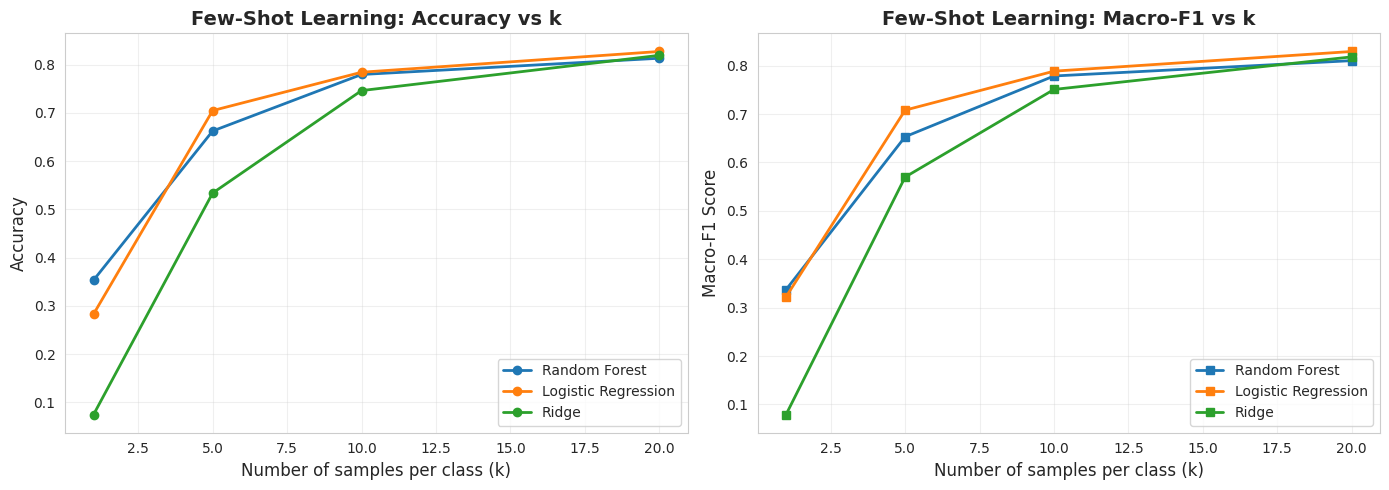

In [26]:
# Plot 1: Performance vs k for few-shot learning
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

k_values = sorted(rf_few.keys())
classifiers = ['Random Forest', 'Logistic Regression', 'Ridge']
results_dicts = [rf_few, lr_few, ridge_few]

# Accuracy plot
for clf_name, results in zip(classifiers, results_dicts):
    accs = [results[k]['accuracy'] for k in k_values]
    axes[0].plot(k_values, accs, marker='o', label=clf_name, linewidth=2)

axes[0].set_xlabel('Number of samples per class (k)', fontsize=12)
axes[0].set_ylabel('Accuracy', fontsize=12)
axes[0].set_title('Few-Shot Learning: Accuracy vs k', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Macro-F1 plot
for clf_name, results in zip(classifiers, results_dicts):
    f1s = [results[k]['macro_f1'] for k in k_values]
    axes[1].plot(k_values, f1s, marker='s', label=clf_name, linewidth=2)

axes[1].set_xlabel('Number of samples per class (k)', fontsize=12)
axes[1].set_ylabel('Macro-F1 Score', fontsize=12)
axes[1].set_title('Few-Shot Learning: Macro-F1 vs k', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


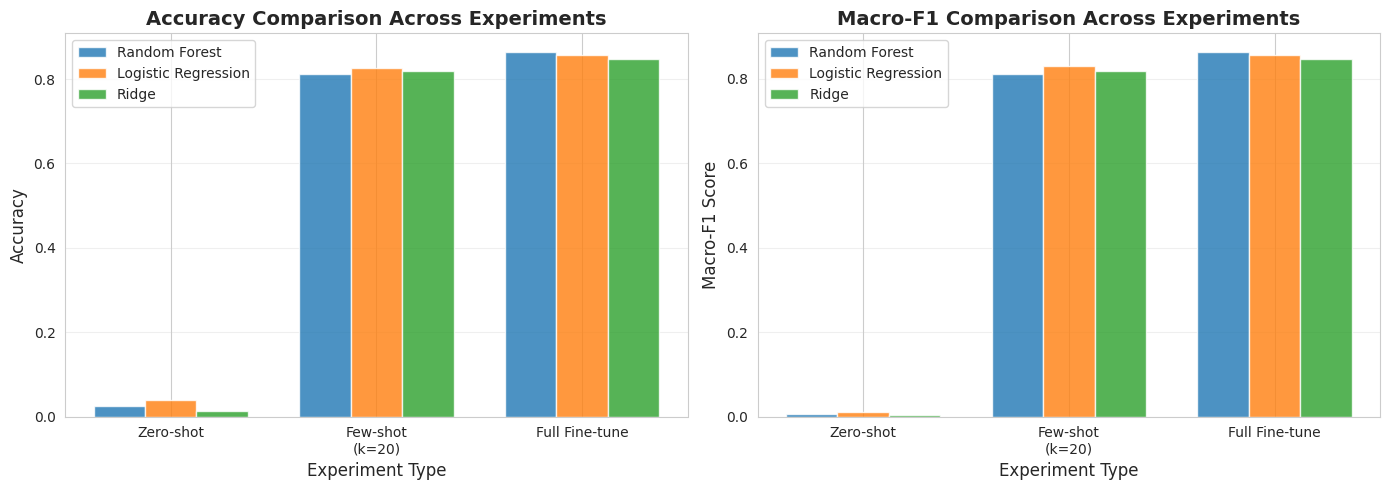

In [27]:
# Plot 2: Comparison across all experiments
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

experiments = ['Zero-shot', 'Few-shot\n(k=20)', 'Full Fine-tune']
x_pos = np.arange(len(experiments))
width = 0.25

# Accuracy comparison
for i, clf_name in enumerate(classifiers):
    accs = [
        zero_shot_results[clf_name]['accuracy'],
        few_shot_k20[clf_name]['accuracy'],
        full_finetune_results[clf_name]['accuracy']
    ]
    axes[0].bar(x_pos + i*width, accs, width, label=clf_name, alpha=0.8)

axes[0].set_xlabel('Experiment Type', fontsize=12)
axes[0].set_ylabel('Accuracy', fontsize=12)
axes[0].set_title('Accuracy Comparison Across Experiments', fontsize=14, fontweight='bold')
axes[0].set_xticks(x_pos + width)
axes[0].set_xticklabels(experiments)
axes[0].legend()
axes[0].grid(True, alpha=0.3, axis='y')

# Macro-F1 comparison
for i, clf_name in enumerate(classifiers):
    f1s = [
        zero_shot_results[clf_name]['macro_f1'],
        few_shot_k20[clf_name]['macro_f1'],
        full_finetune_results[clf_name]['macro_f1']
    ]
    axes[1].bar(x_pos + i*width, f1s, width, label=clf_name, alpha=0.8)

axes[1].set_xlabel('Experiment Type', fontsize=12)
axes[1].set_ylabel('Macro-F1 Score', fontsize=12)
axes[1].set_title('Macro-F1 Comparison Across Experiments', fontsize=14, fontweight='bold')
axes[1].set_xticks(x_pos + width)
axes[1].set_xticklabels(experiments)
axes[1].legend()
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()


## Confusion Matrices


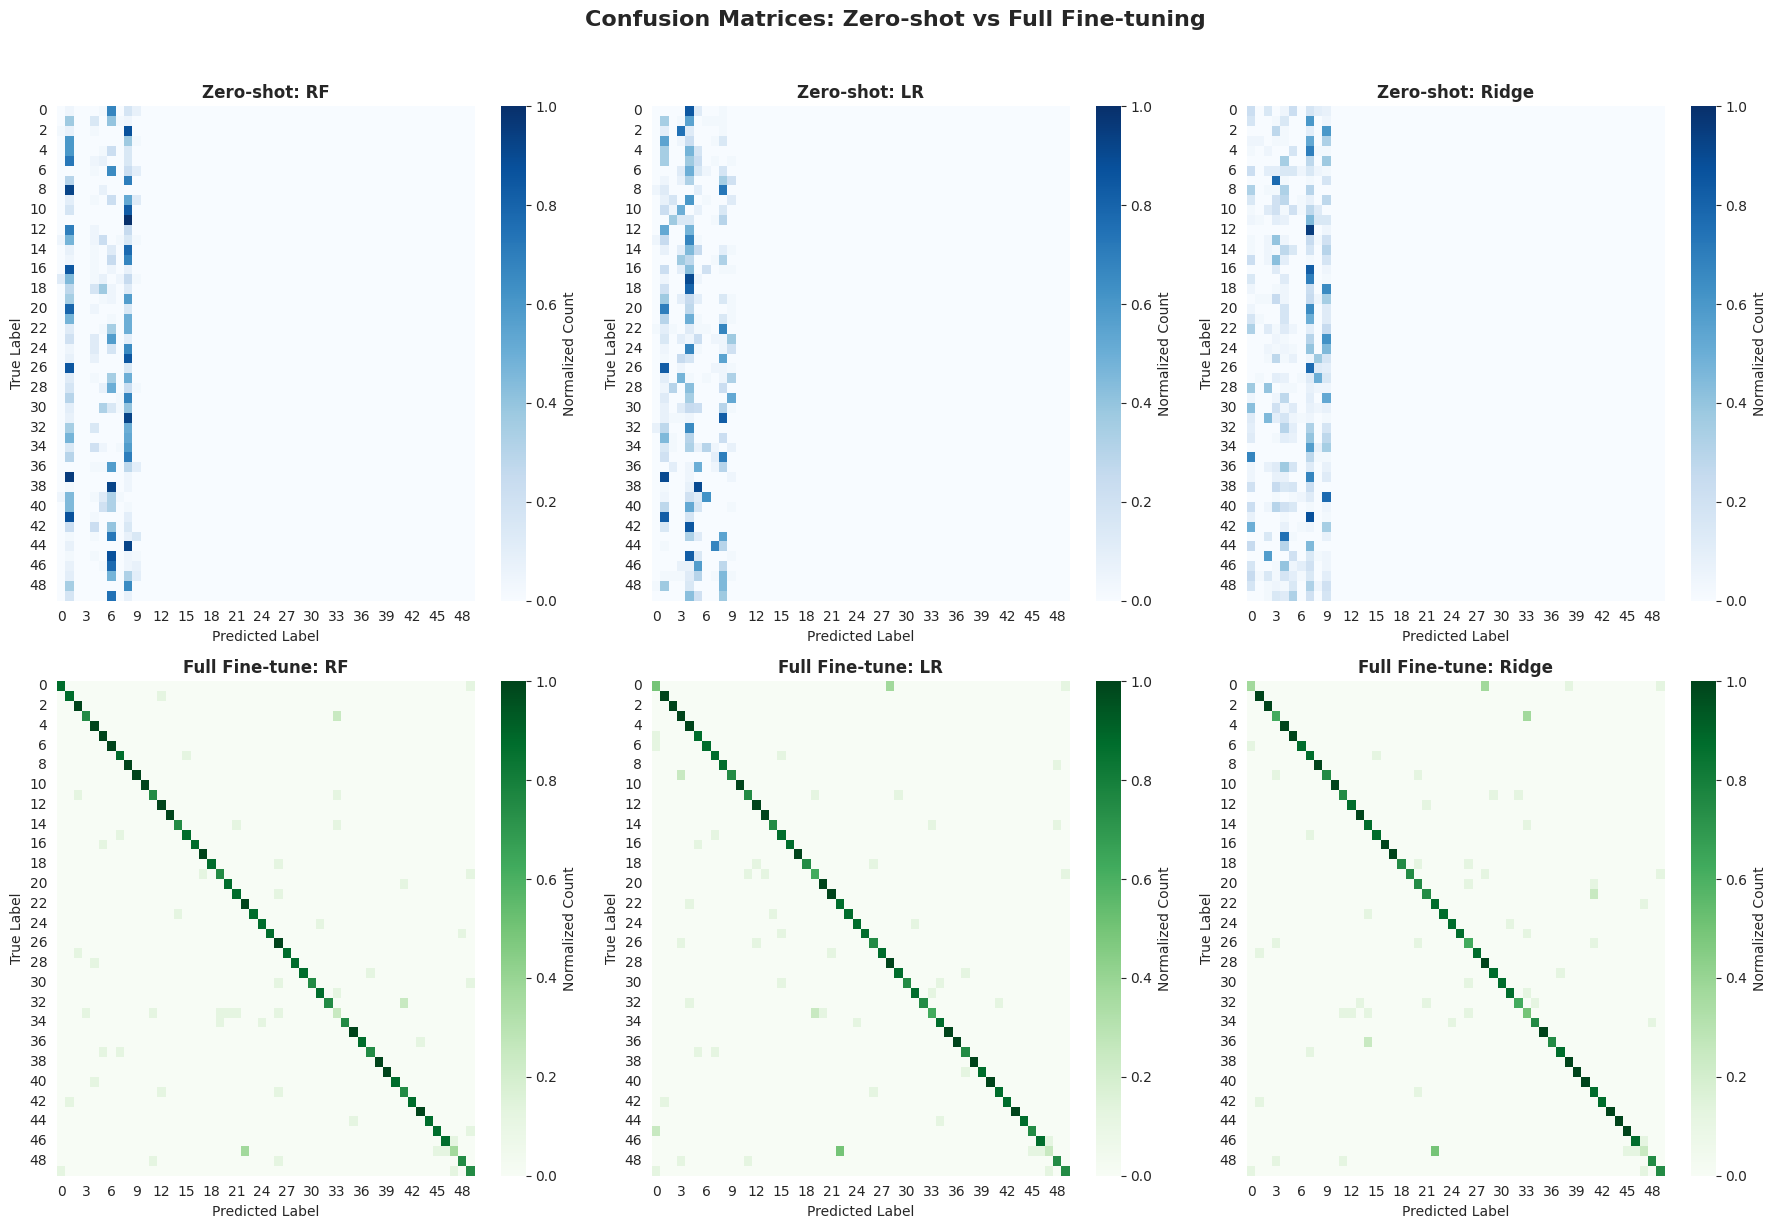


Note: Confusion matrices show normalized values (proportions).
For 50 classes, individual cells may be small. Focus on diagonal patterns.


In [28]:
# Get zero-shot predictions for confusion matrices
_, _, cm_rf_zs, preds_rf_zs = zero_shot_baseline(
    RandomForestClassifier(n_estimators=500, n_jobs=-1, random_state=42),
    X_gtzan_flat, y_gtzan, X_esc_flat, y_esc, return_all_metrics=True
)

_, _, cm_lr_zs, preds_lr_zs = zero_shot_baseline(
    LogisticRegression(max_iter=2000, n_jobs=-1, random_state=42),
    X_gtzan_flat, y_gtzan, X_esc_flat, y_esc, return_all_metrics=True
)

_, _, cm_ridge_zs, preds_ridge_zs = zero_shot_baseline(
    RidgeClassifier(alpha=1.0, random_state=42),
    X_gtzan_flat, y_gtzan, X_esc_flat, y_esc, return_all_metrics=True
)

# Plot confusion matrices
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Zero-shot confusion matrices
cms_zs = [cm_rf_zs, cm_lr_zs, cm_ridge_zs]
clf_names_short = ['RF', 'LR', 'Ridge']

for i, (cm, name) in enumerate(zip(cms_zs, clf_names_short)):
    # Normalize confusion matrix
    cm_norm = cm.astype('float') / (cm.sum(axis=1)[:, np.newaxis] + 1e-10)  # Add small epsilon to avoid division by zero

    sns.heatmap(cm_norm, annot=False, fmt='.2f', cmap='Blues', ax=axes[0, i],
                cbar_kws={'label': 'Normalized Count'}, vmin=0, vmax=1)
    axes[0, i].set_title(f'Zero-shot: {name}', fontsize=12, fontweight='bold')
    axes[0, i].set_xlabel('Predicted Label', fontsize=10)
    axes[0, i].set_ylabel('True Label', fontsize=10)

# Full fine-tuning confusion matrices
cms_full = [cm_rf_full, cm_lr_full, cm_ridge_full]

for i, (cm, name) in enumerate(zip(cms_full, clf_names_short)):
    # Normalize confusion matrix
    cm_norm = cm.astype('float') / (cm.sum(axis=1)[:, np.newaxis] + 1e-10)

    sns.heatmap(cm_norm, annot=False, fmt='.2f', cmap='Greens', ax=axes[1, i],
                cbar_kws={'label': 'Normalized Count'}, vmin=0, vmax=1)
    axes[1, i].set_title(f'Full Fine-tune: {name}', fontsize=12, fontweight='bold')
    axes[1, i].set_xlabel('Predicted Label', fontsize=10)
    axes[1, i].set_ylabel('True Label', fontsize=10)

plt.suptitle('Confusion Matrices: Zero-shot vs Full Fine-tuning', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

print("\nNote: Confusion matrices show normalized values (proportions).")
print("For 50 classes, individual cells may be small. Focus on diagonal patterns.")

## Detailed Results Table


In [29]:
# Create detailed results table for all k values
detailed_results = []

for clf_name, results_dict in zip(['Random Forest', 'Logistic Regression', 'Ridge'],
                                   [rf_few, lr_few, ridge_few]):
    # Zero-shot
    detailed_results.append({
        'Classifier': clf_name,
        'Experiment': 'Zero-shot',
        'k': 0,
        'Accuracy': zero_shot_results[clf_name]['accuracy'],
        'Macro-F1': zero_shot_results[clf_name]['macro_f1']
    })

    # Few-shot for each k
    for k in sorted(results_dict.keys()):
        detailed_results.append({
            'Classifier': clf_name,
            'Experiment': 'Few-shot',
            'k': k,
            'Accuracy': results_dict[k]['accuracy'],
            'Macro-F1': results_dict[k]['macro_f1']
        })

    # Full fine-tuning
    detailed_results.append({
        'Classifier': clf_name,
        'Experiment': 'Full Fine-tune',
        'k': 'all',
        'Accuracy': full_finetune_results[clf_name]['accuracy'],
        'Macro-F1': full_finetune_results[clf_name]['macro_f1']
    })

detailed_df = pd.DataFrame(detailed_results)
print("\n" + "=" * 80)
print("DETAILED RESULTS")
print("=" * 80)
print(detailed_df.to_string(index=False))


DETAILED RESULTS
         Classifier     Experiment   k  Accuracy  Macro-F1
      Random Forest      Zero-shot   0  0.024500  0.006870
      Random Forest       Few-shot   1  0.353333  0.337277
      Random Forest       Few-shot   5  0.662286  0.653276
      Random Forest       Few-shot  10  0.779333  0.778766
      Random Forest       Few-shot  20  0.813000  0.810476
      Random Forest Full Fine-tune all  0.865000  0.864687
Logistic Regression      Zero-shot   0  0.040000  0.009652
Logistic Regression       Few-shot   1  0.283077  0.322488
Logistic Regression       Few-shot   5  0.704571  0.708188
Logistic Regression       Few-shot  10  0.784000  0.788736
Logistic Regression       Few-shot  20  0.827000  0.829389
Logistic Regression Full Fine-tune all  0.857500  0.856379
              Ridge      Zero-shot   0  0.012000  0.004036
              Ridge       Few-shot   1  0.074872  0.079105
              Ridge       Few-shot   5  0.533714  0.569929
              Ridge       Few-shot  10

## Summary

This notebook implements three transfer learning experiments:

1. **Zero-shot**: Train classifier on GTZAN (music genres), test on ESC-50 (environmental sounds)
2. **Few-shot**: Train on GTZAN + k samples per class from ESC-50, test on remaining ESC-50 samples
3. **Full Fine-tuning**: Train classifier on all ESC-50 data (upper bound performance)

### Key Results to Report:
- **Zero-shot performance**: Shows baseline generalization from music to environmental sounds
- **Few-shot learning curves**: Performance improvement as k increases (k=1, 5, 10, 20)
- **Full fine-tuning**: Upper bound showing best possible performance
- **Confusion matrices**: Visualize which classes are confused with each other
- **Macro-F1 scores**: Important for imbalanced datasets (all classes weighted equally)

### Next Steps:
1. Run all cells sequentially
2. Review the summary tables and visualizations
3. Analyze confusion matrices to identify which sound categories are most confused
4. Compare performance across classifiers (Random Forest, Logistic Regression, Ridge)
5. Document findings in your report/poster
